# Extracting data from DICOM files
### This notebook extract data from Dicom files using the dicomTags.

#### Installing required packages:

1. Create a new environment (https://docs.python.org/3/library/venv.html)

```python
python3 -m venv /path/to/new/virtual/environment
```
2. Activate the new environment

```python
source env/bin/activate
```

3. Install required packages

```python
pip install -r requirements.txt
```

4. Run the notebook.  :)

In [1]:
import pandas as pd
import numpy as np
from pydicom import dcmread
import re

DICOM_file: The path containing the Dicom File.
tags_file_osiris: the file containing the dicomTags to be extracted.
For this example the original excel file of Christophe is used.

In [2]:
DICOM_file = dcmread("dicom_file.dcm")
tags_file_osiris = pd.read_excel(
    "modele_osiris_radiomics.xlsx", sheet_name="Feuil1", header=0
)

#### Display tags_file_osiris and Dicom File

In [3]:
tags_file_osiris

,ObjectClass,ObjectProperty,Source,DataElementConceptDef,Example,FormatConceptualDomain,Mandatory/Optional,web link,CLB/CREATIS,Unnamed: 9,CURIE/LITO,Unnamed: 11,IGR,Unnamed: 13,ICO/Nantes,Unnamed: 15,BERGONIE/Bordeaux,Unnamed: 17
0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Standard utilisé,Référence,Standard utilisé,Référence,Standard utilisé,Référence,Standard utilisé,Référence,Standard utilisé,Référence
1,Observation,Patient's Size,"dicomTag (0010,1020)",NaN,NaN,string,Mandatory,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,Observation,Patient’s Weight,"dicomTag (0010,1030)",NaN,NaN,string,Mandatory,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,Equipment,Manufacturer’s Model Name,"dicomTag (0008,1090)",NaN,NaN,string,Optional,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
105,RADIOMICS_ImageFilter,BoundaryCondition,NaN,zero padding || mirror padding || periodic pad...,zero padding,string,Optional,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
106,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
107,RADIOMICS_FEATURE,Id,NaN,IBSI id,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
108,RADIOMICS_FEATURE,Name,NaN,IBSI name,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [4]:
print(DICOM_file)

Dataset.file_meta -------------------------------
(0002, 0000) File Meta Information Group Length  UL: 196
(0002, 0001) File Meta Information Version       OB: b'\x00\x01'
(0002, 0002) Media Storage SOP Class UID         UI: MR Image Storage
(0002, 0003) Media Storage SOP Instance UID      UI: 1.3.6.1.4.1.14519.5.2.1.4429.7055.169383040232904917519603822011
(0002, 0010) Transfer Syntax UID                 UI: Explicit VR Little Endian
(0002, 0012) Implementation Class UID            UI: 1.2.40.0.13.1.1.1
(0002, 0013) Implementation Version Name         SH: 'dcm4che-1.4.35'
-------------------------------------------------
(0008, 0005) Specific Character Set              CS: 'ISO_IR 100'
(0008, 0008) Image Type                          CS: ['ORIGINAL', 'PRIMARY', 'M', 'NORM', 'DIS2D']
(0008, 0012) Instance Creation Date              DA: '19920402'
(0008, 0013) Instance Creation Time              TM: '091823.406000'
(0008, 0016) SOP Class UID                       UI: MR Image Storage
(0

### Extracting the data and building a data frame

In [5]:
list_tags = []
dicom_df = pd.DataFrame(columns=["tag", "name", "value"])

# extraction of dicomTags from the excel file
for j in range(len(tags_file_osiris)):
    try:
        tag_ext = re.search(r"\((.*?)\)", tags_file_osiris["Source"][j]).group(1)
        tag_conv = "0x" + tag_ext[0:4] + tag_ext[5:]
        list_tags.append(tag_conv)
    except:
        pass

# searching for the tags in the dicom file and building the dataframe
for i in list_tags:
    try:
        df_tag = str(DICOM_file[i].tag)
        df_name = DICOM_file[i].name
        df_value = DICOM_file[i].value

        dicom_df = dicom_df.append(
            {"tag": df_tag, "name": df_name, "value": df_value}, ignore_index=True
        )

    except:
        pass


dicom_df

,tag,name,value
0,"(0010, 1030)",Patient's Weight,170.550753
1,"(0008, 1090)",Manufacturer's Model Name,Verio
2,"(0008, 0070)",Manufacturer,SIEMENS
3,"(0020, 000d)",Study Instance UID,1.3.6.1.4.1.14519.5.2.1.4429.7055.304625516276...
4,"(0008, 1030)",Study Description,FH-HEAD^Brain Protocols
5,"(0020, 0011)",Series Number,11
6,"(0020, 000e)",Series Instance UID,1.3.6.1.4.1.14519.5.2.1.4429.7055.197322826283...
7,"(0018, 1020)",Software Versions,syngo MR B17
8,"(0018, 0010)",Contrast/Bolus Agent,10cc Multihance
9,"(0008, 0018)",SOP Instance UID,1.3.6.1.4.1.14519.5.2.1.4429.7055.169383040232...


#### Exporting to CSV

In [6]:
dicom_df.to_csv('dicom_data-osiris.csv')

#### Just for fun!

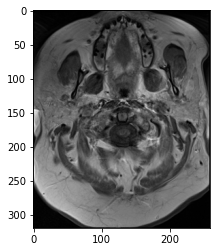

In [7]:
import matplotlib.pyplot as plt

plt.imshow(DICOM_file.pixel_array, cmap=plt.cm.gray)
plt.show()